In [ ]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

### vgg feature analysis 

In [ ]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *



In [ ]:
# retrieve sketch paths
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
# path_to_sketches = '../sketches'
path_to_sketches = '/home/jefan/kiddraw/analysis/museumdraw/sketches'
sketch_paths = sorted(list_files(path_to_sketches))

In [4]:
## number of sketch paths 
print 'Number of sketch paths = {}'.format(len(sketch_paths))

Number of sketch paths = 532


## extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract (mini verison of) adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png_mini' --layer_ind=6 --cohort='adult'`

In [5]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']            
    F = np.load('/home/jefan/kiddraw/analysis/museumdraw/python/features/FEATURES_{}_{}.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('/home/jefan/kiddraw/analysis/museumdraw/python/features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

In [181]:
## Chose Layer
thisLayer=6

In [182]:
## load in kid features
KF, KM = load_features('kid',thisLayer)
KF, KM = remove_practice_trials(KF, KM)
KM = KM.reset_index(drop=True)

print np.shape(KF)

(387, 4096)


### figure out how many drawings we have in each category x age

In [183]:
## add additional column that coarse grains age
def coarse_grain_age(row):
    if row['age'] > 6:
        val = 'older'
    elif row['age'] <= 6:
        val = 'younger'
    return val

def coarse_grain_age_2(row):
    if row['age'] > 7: # ages 8-10
        val = 'oldest'
    elif row['age'] <= 7 & row['age']>5: # ages 6 & 7
        val = 'middle'
    elif row['age'] <= 5: # ages 3 4 5
        val = 'youngest'
    return val


KM['coarse_age'] = KM.apply(coarse_grain_age_2, axis=1)

## subset labels that have at least some drawings of them from each age category
youngest_labels = KM[KM['coarse_age'] == 'youngest']['label'].values
middle_labels = KM[KM['coarse_age'] == 'middle']['label'].values
oldest_labels = KM[KM['coarse_age'] == 'oldest']['label'].values

## list of labels that are in both younger and older age categories
common_labels = list(np.intersect1d(youngest_labels,oldest_labels))
common_labels = list(np.intersect1d(common_labels,middle_labels))                  

print 'We have {} labels that are common to both all 3 age cohorts.'.format(len(common_labels))


We have 24 labels that are common to both all 3 age cohorts.


In [184]:
def subset_labels(F,M, labels):
    '''
    if labels == common_labels, then only include labels that are common to younger and older cohort
    if labels == sufficient_data_labels, then subset by list of labels in which we have 'sufficient data', i.e., have >=thresh drawings/class
    '''
    _F = F[M['label'].isin(labels),:]
    _M = M[M['label'].isin(labels)]
    return _F, _M

## get list of labels in which we have 'sufficient data', i.e., have >=5 drawings/class
thresh = 3
sufficient_data_labels = [] 
for cl in common_labels:
    num_young_sketches = len(np.where(KM[KM.label==cl]['coarse_age'].values=='youngest')[0])
    num_middle_sketches = len(np.where(KM[KM.label==cl]['coarse_age'].values=='middle')[0])
    num_older_sketches = len(np.where(KM[KM.label==cl]['coarse_age'].values=='oldest')[0])
    if (num_young_sketches>=thresh) & (num_middle_sketches>=thresh) & (num_older_sketches>=thresh):
        sufficient_data_labels.append(cl)        
        
print 'We have {} classes with sufficient data.'.format(len(sufficient_data_labels))

np.shape(sufficient_data_labels)
for l in sufficient_data_labels:
    print "%s -- %d drawings" % (l,sum(KM['label'] == l ))

We have 13 classes with sufficient data.
banana -- 17 drawings
boat -- 18 drawings
car -- 18 drawings
carrot -- 17 drawings
chair -- 20 drawings
couch -- 16 drawings
cup -- 17 drawings
flower -- 20 drawings
foot -- 16 drawings
ice cream -- 17 drawings
rabbit -- 21 drawings
shoe -- 18 drawings
train -- 23 drawings


In [185]:
## subset to only use the labels with either COMMON LABELS or SUFFICIENT DATA (see cell above)
KF, KM = subset_labels(KF, KM, common_labels)
KM = KM.reset_index(drop=True)

In [186]:
## Print out number of drawings in each age & age group
print "3 yr olds made %s drawings" % (sum(KM['age'] == 3 ))
print "4 yr olds made %s drawings" % (sum(KM['age'] == 4 ))
print "5 yr olds made %s drawings" % (sum(KM['age'] == 5 ))
print "6 yr olds made %s drawings" % (sum(KM['age'] == 6 ))
print "7 yr olds made %s drawings" % (sum(KM['age'] == 7 ))
print "8 yr olds made %s drawings" % (sum(KM['age'] == 8 ))
print "9 yr olds made %s drawings" % (sum(KM['age'] == 9 ))
print "10 yr olds made %s drawings" % (sum(KM['age'] == 10 ))


print "younger kids made %s drawings" % (sum(KM['coarse_age'] == 'youngest' ))
print "middle kids made %s drawings" % (sum(KM['coarse_age'] == 'middle' ))
print "older kids made %s drawings" % (sum(KM['coarse_age'] == 'oldest' ))

3 yr olds made 2 drawings
4 yr olds made 28 drawings
5 yr olds made 54 drawings
6 yr olds made 58 drawings
7 yr olds made 42 drawings
8 yr olds made 87 drawings
9 yr olds made 8 drawings
10 yr olds made 53 drawings
younger kids made 84 drawings
middle kids made 100 drawings
older kids made 148 drawings


#### quick classification tests

In [187]:
#### Quick classification test
FEAT = KF
LABELS = KM.label.values
AGES = KM.age.values

# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.25, random_state=0)
# clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

run_this = 0
if run_this:
    # cross-validated
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=3)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.421686746988


In [189]:
## see how recognizability changes with age?
scores = []
num_samples = []
age_range = np.arange(4,11)

# width of moving window in # of trials    
window_size = 4
lb = int(min(KM.age.values))
ub = int(max(KM.age.values))
num_windows = ub-lb-window_size+2 ##     

for n in np.arange(num_windows):
    start = lb + n
    end = lb + n + window_size
    ind = KM.index[(KM['age'] >= start) & (KM['age'] < end)]
    meta = KM.loc[ind]
    subFeat = KF[ind.tolist()]

    FEAT = subFeat
    LABELS = meta.label.values

    # single train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        FEAT, LABELS, test_size=0.25, random_state=3)
    clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
#     clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
    print '{}-{}y'.format(start, end-1), len(LABELS),clf.score(X_test, y_test)
    num_samples.append(len(LABELS))
    scores.append(clf.score(X_test, y_test))
    

3-6y 142 0.166666666667
4-7y 182 0.239130434783
5-8y 241 0.360655737705
6-9y 195 0.489795918367
7-10y 190 0.375


### Extract adult drawing features

In [208]:
## load in adult features
AF, AM = load_features('adult',thisLayer)
AF, AM = remove_practice_trials(AF, AM)
AM = AM.reset_index(drop=True)
print np.shape(AF)

np.unique(AM.label.values)

(8000, 4096)


array(['banana', 'bird', 'boat', 'car', 'carrot', 'chair', 'couch', 'cup',
       'flower', 'foot', 'frog', 'ice cream', 'phone', 'rabbit', 'shoe',
       'train'], dtype=object)

In [194]:
## which label set are we using? common_labels or sufficient_data_labels
these_labels = common_labels

## set up lookup table to cover discrepancies in category label assignments
lookup = dict(zip(these_labels,these_labels))
if 'bike' in lookup.keys():
    lookup['bike'] = 'bicycle'
    
## subset adult feature matrix and metadata matrix by appropriate labelset
AF, AM = subset_labels(AF, AM, [lookup[i] for i in these_labels])
AM = AM.reset_index(drop=True)    

In [204]:
np.unique(AM.label.values)

array(['banana', 'bird', 'boat', 'car', 'carrot', 'chair', 'couch', 'cup',
       'flower', 'foot', 'frog', 'ice cream', 'phone', 'rabbit', 'shoe',
       'train'], dtype=object)

In [195]:
## apply clustering to organize RDM so that we can see some block diagonal structure
def flatten(x):
    return [item for sublist in x for item in sublist]

## retrieve alpha sorted labels from meta
_labels = np.unique(AM.label.values) # added bll
means=get_class_means(AF, AM.label.values)

af = AffinityPropagation(damping=0.5).fit(means)
labels = af.labels_
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

ordered_objs = []
print('Clusters')
for k in range(n_clusters_):
    class_members = labels == k
    print _labels[class_members]
    ordered_objs.append(list(_labels[class_members]))
    
ordered_objs = np.array(flatten(ordered_objs))

# define standard order to be used for RDM's across layers
standard_order = ordered_objs

## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

Clusters
['carrot' 'chair']
['banana' 'bird' 'car' 'flower' 'frog' 'rabbit']
['phone']
['boat' 'couch' 'cup' 'foot' 'ice cream' 'shoe']
['train']


In [198]:
np.unique(AM.label.values)

array(['banana', 'bird', 'boat', 'car', 'carrot', 'chair', 'couch', 'cup',
       'flower', 'foot', 'frog', 'ice cream', 'phone', 'rabbit', 'shoe',
       'train'], dtype=object)

In [40]:
def get_and_plot_RDM(M,F,cohort,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]
    sns.set_style('white')
    CORRMAT = np.corrcoef(ordered_means)

    sns.set_context('paper')
    fig = plt.figure(figsize=(24,24))
    plt.matshow(CORRMAT)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    # plt.colorbar(ax) creates error for me
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    RDM = CORRMAT
    plt.savefig('./plots/RDM_{}.pdf'.format(cohort))
    return RDM


def get_RDM(M,F,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]    
    RDM = np.corrcoef(ordered_means)
    return RDM

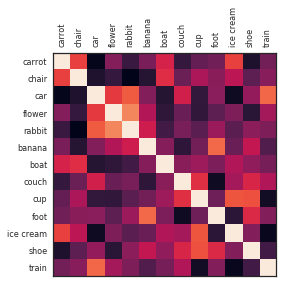

In [41]:

## get and plot sorted adult RDM
ARDM = get_and_plot_RDM(AM, AF,'adult',sort_inds)

In [29]:
sort_inds

[4, 5, 0, 1, 3, 8, 10, 13, 12, 2, 6, 7, 9, 11, 14, 15]

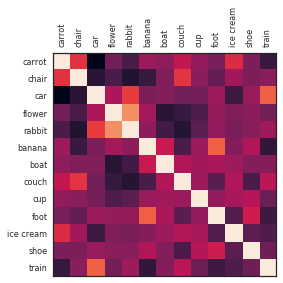

In [42]:
## get and plot sorted kid RDM collapsing across all ages
KRDM = get_and_plot_RDM(KM, KF,'kid',sort_inds)

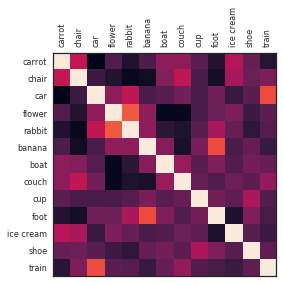

In [43]:
## get RDM for older kids (9,10)
ind = KM.index[KM['coarse_age'] == 'oldest']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
ORDM = get_and_plot_RDM(meta, feat,'oldest',sort_inds)

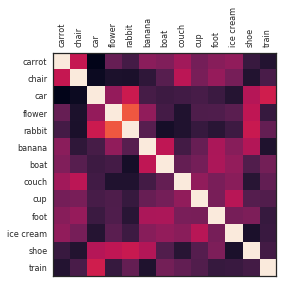

In [44]:
## get RDM for middle kids (6,7)
ind = KM.index[KM['coarse_age'] == 'middle']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
MRDM = get_and_plot_RDM(meta, feat,'middle',sort_inds)

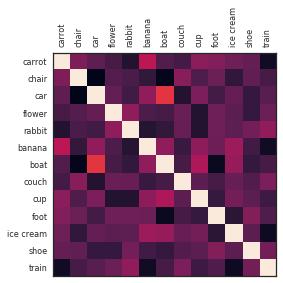

In [45]:
## get RDM for younger kids (3,4,5)
ind = KM.index[KM['coarse_age'] == 'youngest']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
YRDM = get_and_plot_RDM(meta, feat,'youngest',sort_inds)

In [46]:
## print fc7 cross-cohort correlations

dim = KRDM.shape[0]
cor = stats.spearmanr(np.ravel(KRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and overall kid RDM: {}'.format(cor)

print ' '
dim = ORDM.shape[0]
cor = stats.spearmanr(np.ravel(ORDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and OLDER kid RDM: {}'.format(cor)


print ' '
dim = MRDM.shape[0]
cor = stats.spearmanr(np.ravel(MRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and MIDDLE kid RDM: {}'.format(cor)

print ' '
dim = YRDM.shape[0]
cor = stats.spearmanr(np.ravel(YRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and YOUNGER kid RDM: {}'.format(cor)


print ' '
dim = YRDM.shape[0]
cor = stats.spearmanr(np.ravel(YRDM[np.triu_indices(dim,k=1)]),np.ravel(ORDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between OLDER and YOUNGER kid RDM: {}'.format(cor)

Correlation between adult and overall kid RDM: 0.684138646164
 
Correlation between adult and OLDER kid RDM: 0.675919017691
 
Correlation between adult and MIDDLE kid RDM: 0.528825604775
 
Correlation between adult and YOUNGER kid RDM: 0.203353608417
 
Correlation between OLDER and YOUNGER kid RDM: 0.144146992248


### generalize across layers

In [180]:
## which label set are we using? common_labels or sufficient_data_labels
these_labels = common_labels

## function to apply various cleanup operations to adult feat/meta, including deborkifying and subsetting by appropriate labelset
def adult_preproc(AF, AM, these_labels):
    ## set up lookup table to cover discrepancies in category label assignments
    lookup = dict(zip(these_labels,these_labels))
    if 'bike' in lookup.keys():
        lookup['bike'] = 'bicycle'

    ## subset adult feature matrix and metadata matrix by appropriate labelset
    AF, AM = subset_labels(AF, AM, [lookup[i] for i in these_labels])
    AM = AM.reset_index(drop=True)    
    return AF, AM

## function to add coarse grain age and subset according to proper labelset
def preproc_kid(KF, KM,these_labels):    
    KM['coarse_age'] = KM.apply(coarse_grain_age, axis=1)
    ## subset labels that have at least some drawings of them from each age category
    younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
    older_labels = KM[KM['coarse_age'] == 'older']['label'].values
    
    ## subset to only use the labels with either COMMON LABELS or SUFFICIENT DATA (see cell above)
    KF, KM = subset_labels(KF, KM, these_labels)
    KM = KM.reset_index(drop=True)    
    return KF, KM

## make sure directory for RDM exists
if not os.path.exists('./rdm'):
    os.makedirs('./rdm')

In [160]:
## load in adult features
really_run = 0
if really_run:
    for layer_num in np.arange(7):
        print 'Loading in adult features for layer {}...'.format(layer_num)
        AF, AM = load_features('adult',layer_num)
        AF, AM = remove_practice_trials(AF, AM)
        AM = AM.reset_index(drop=True)
        AF, AM = adult_preproc(AF, AM, these_labels)
        print 'Shape of adult feature tensor: {}'.format(np.shape(AF))

        ## get RDM
        cohort = 'adult'
        print 'Getting and saving RDM...'
        RDM = get_RDM(AM, AF,sort_inds)
        ## save out RDM as npy
        np.save('./rdm/RDM_{}_{}.npy'.format('adult',layer_num),ARDM)


Loading in adult features for layer 0...


KeyboardInterrupt: 

In [64]:
KM

,label,age,session,coarse_age
0,banana,4,E1c_1510691847400,younger
1,banana,5,E1c_1510253748384,younger
2,banana,5,E1c_1510786719020,younger
3,banana,5,E1c_1511301440421,younger
4,banana,6,E1c_1510782034963,younger
5,banana,6,E1c_1511292022297,younger
6,banana,6,E1c_1511292286803,younger
7,banana,6,E1c_1511293092153,younger
8,banana,7,E1c_1511301009480,older
9,banana,8,E1c_1510254933095,older


In [161]:
really_run = 0
if really_run:
    ## loop through all kid layers and save out their RDM
    for layer_num in np.arange(7):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)
        print 'Shape of kid feature tensor: {}'.format(np.shape(KF))

        ## get RDM
        print 'Getting and saving RDM...'
        cohort = 'kid'
        KRDM = get_RDM(KM, KF,sort_inds)
        ## save out RDM as npy
        np.save('./rdm/RDM_{}_{}.npy'.format('kid',layer_num),KRDM)
        
        ## get RDM for older kids (7,8,9,10)
        ind = KM.index[KM['coarse_age'] == 'older']
        meta = KM.loc[ind]
        feat = KF[ind.tolist()]
        ORDM = get_RDM(meta, feat,sort_inds)
        np.save('./rdm/RDM_{}_{}.npy'.format('older',layer_num),ORDM)
                
        ## get RDM for younger kids (3,4,5,6)            
        ind = KM.index[KM['coarse_age'] == 'younger']
        meta = KM.loc[ind]
        feat = KF[ind.tolist()]
        YRDM = get_RDM(meta, feat,sort_inds)
        np.save('./rdm/RDM_{}_{}.npy'.format('younger',layer_num),YRDM)          

        print 'Saved KID RDMs for layer {}!'.format(layer_num)


In [172]:
corr_out_older=np.zeros(7)
corr_out_younger=np.zeros(7)
corr_out_youngervolder=np.zeros(7)
corr_out_kidvadult=np.zeros(7)

for layer_num in np.arange(7):
    younger = np.load('/home/jefan/kiddraw/analysis/museumdraw/python/rdm/RDM_younger_{}.npy'.format(layer_num))
    older = np.load('/home/jefan/kiddraw/analysis/museumdraw/python/rdm/RDM_older_{}.npy'.format(layer_num))
    adult = np.load('/home/jefan/kiddraw/analysis/museumdraw/python/rdm/RDM_adult_{}.npy'.format(layer_num))
    kid = np.load('/home/jefan/kiddraw/analysis/museumdraw/python/rdm/RDM_kid_{}.npy'.format(layer_num))
    dim = older.shape[0]
    
    cor = stats.spearmanr(np.ravel(older[np.triu_indices(dim,k=1)]),np.ravel(adult[np.triu_indices(dim,k=1)]))[0]
    print 'Correlation between ADULT and OLDER kid RDM: {}'.format(cor)
    corr_out_older[layer_num]=cor
    
    cor = stats.spearmanr(np.ravel(younger[np.triu_indices(dim,k=1)]),np.ravel(adult[np.triu_indices(dim,k=1)]))[0]
    print 'Correlation between ADULT and YOUNGER kid RDM: {}'.format(cor)
    corr_out_younger[layer_num]=cor
    
    cor = stats.spearmanr(np.ravel(younger[np.triu_indices(dim,k=1)]),np.ravel(older[np.triu_indices(dim,k=1)]))[0]
    print 'Correlation between OLDER and YOUNGER kid RDM: {}'.format(cor)
    corr_out_youngervolder[layer_num]=cor

    # wrong size RDM?
#     cor = stats.spearmanr(np.ravel(kid[np.triu_indices(dim,k=1)]),np.ravel(adult[np.triu_indices(dim,k=1)]))[0]
#     print 'Correlation between ADULT and ALL kid RDM: {}'.format(cor)
#     corr_out_kidvadult[layer_num]=cor

    

Correlation between ADULT and OLDER kid RDM: 0.215021876519
Correlation between ADULT and YOUNGER kid RDM: 0.0740745885131
Correlation between OLDER and YOUNGER kid RDM: 0.349052017501
Correlation between ADULT and OLDER kid RDM: 0.205548996458
Correlation between ADULT and YOUNGER kid RDM: 0.000631988332523
Correlation between OLDER and YOUNGER kid RDM: 0.320362525175
Correlation between ADULT and OLDER kid RDM: 0.248857559553
Correlation between ADULT and YOUNGER kid RDM: 0.0404889228419
Correlation between OLDER and YOUNGER kid RDM: 0.359656920619
Correlation between ADULT and OLDER kid RDM: 0.435294117647
Correlation between ADULT and YOUNGER kid RDM: 0.119293006459
Correlation between OLDER and YOUNGER kid RDM: 0.386971317453
Correlation between ADULT and OLDER kid RDM: 0.63703034933
Correlation between ADULT and YOUNGER kid RDM: 0.367747760261
Correlation between OLDER and YOUNGER kid RDM: 0.444773942635
Correlation between ADULT and OLDER kid RDM: 0.695937217862
Correlation betw

In [178]:
np.round(corr_out_younger,3)


array([ 0.074,  0.001,  0.04 ,  0.119,  0.368,  0.464,  0.49 ])

In [179]:
np.round(corr_out_older,3)

array([ 0.215,  0.206,  0.249,  0.435,  0.637,  0.696,  0.72 ])

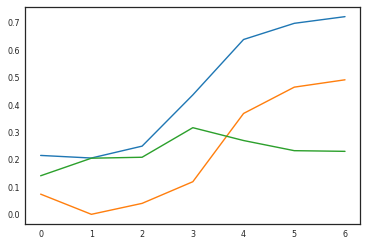

In [163]:

x=np.arange(7)
import matplotlib.pyplot as plt
plt.plot(x,corr_out_older)
plt.plot(x,corr_out_younger)



In [118]:
corr_out

[]

array([[  1.76875501e-321],
       [  1.77369567e-321],
       [  1.77863633e-321],
       [  1.78357698e-321],
       [  1.78851764e-321],
       [  1.79345829e-321]])

In [ ]:
def get_rdm_resampled(layer,standard_order,iteration):

### JACKKNIFE RESAMPLING OF CLASSES (https://en.wikipedia.org/wiki/Jackknife_resampling)    
# 1: exhaustively subset 15 of 16 categories, and compute cross-domain similarity in each case
# 2: variance estimate = (n-1)/n  *   Sum([xi - x.i]^2)
#          where x.i = (1/n) * Sum(xi), the average of all subsamples
jacks = np.roll(range(Xmeans.shape[0]),iteration)[:Xmeans.shape[0]-1]
Xmeans = Xmeans[jacks,:]  